In [1]:
import matplotlib.pyplot as plt
import numpy as np
import scipy
import skimage

In [2]:
def root_mean_square_error(x_interp, y_interp, function):
    return np.sqrt(1/len(x_interp) * np.sum(np.power((function(x_interp) - y_interp), 2)))

def mean_square_error(x_interp, y_interp, function):
    return np.multiply(1/len(x_interp), np.sum((function(x_interp) - y_interp)**2))

def mean_square_error_with_datapoints(x_interp, y_interp, y_datapoints):
    return np.multiply(1/x_interp, np.sum((y_datapoints[:len(y_datapoints)] - y_interp[:len(y_datapoints)])**2))

def mean_square_error_2D(original_data, tested_data):
    rows, cols = np.shape(tested_data)
    sum = 0
    for row in range(rows):
      sum += mean_square_error_with_datapoints(cols, original_data[row], tested_data[row])
    return sum

In [3]:
def f1(x):
    return np.sin(x)

def f2(x):
    return np.sin(np.power(x, -1))

def f3(x):
    return np.sign(np.sin(8 * x))

In [4]:
def kernel_interpolate(x_input, y_input, x_interp, kernel):
    y_interp = np.zeros_like(x_interp)
    kernel_width = np.median(np.diff(x_input))
    for i, x in enumerate(x_interp):
        weights = kernel(np.divide((x - x_input), kernel_width))
        y_interp[i] = np.divide(np.sum(weights * y_input), np.sum(weights))
    return y_interp

def kernel_interpolate_with_variable_widths(x_input, y_input, x_interp, kernel):
    y_interp = np.zeros_like(x_interp)
    kernel_widths = []

    for i in range(len(x_input) - 1):
      kernel_widths.append(np.abs(x_input[i] -  x_input[i + 1]))

    for j, x in enumerate(x_interp):
        index = 0
        if np.abs(x_interp[j] -  kernel_widths[index]) > np.abs(x_interp[j] - kernel_widths[index + 1]):
            index += 1
        weights = kernel(np.divide((x - x_input), kernel_widths[index]))
        y_interp[j] = np.divide(np.sum(weights * y_input), np.sum(weights))
    return y_interp



def interpolate_2D(data, interpolating_function, point_multiplier, kernel):
    rows, cols = data.shape
    row_interpolated = np.zeros((rows, cols * point_multiplier))

    for i in range(rows):
      x_input = np.arange(cols)
      y_input = data[i, :]
      x_interp = np.linspace(0, cols - 1, cols * point_multiplier)
      row_interpolated[i, :] = interpolating_function(x_input, y_input, x_interp, kernel)

    result = np.zeros((rows * point_multiplier, cols * point_multiplier))
    for j in range(cols * point_multiplier):
      x_input = np.arange(rows)
      y_input = row_interpolated[:, j]
      x_interp = np.linspace(0, rows - 1, rows * point_multiplier)
      result[:, j] = interpolating_function(x_input, y_input, x_interp, kernel)
    return result

def sample_and_hold(t):
    return np.where((t >= 0) & (t < 1), 1, 0)

def nearest_neighbour(t):
    return np.where((t >= -1/2) & (t < 1/2), 1, 0)

def linear(t):
    return np.where((t >= - 1) & (t < 1), 1 - abs(t), 0)

def sinc(t):
  t_safe = np.where(t == 0, 1e-20, t)
  return np.where(t == 0, 1, np.divide(np.sin(np.pi * t_safe), t_safe))

def hamming_sinc(t):
    t_safe = np.where(t == 0, 1e-20, t)
    return np.where(t == 0, 1, (np.divide(np.sin(np.pi * t_safe), t_safe) * (0.54 - 0.46 * np.cos(np.pi * 2 * t_safe))))

def cubic_spline(t):
    return np.where(
        (t >= -2) & (t <= 2),
            np.where(
                (t >= 0) & (t <= 1), (3/2 * t **3) - (5/2 * t **2) + 1,
                      np.where(
                          (t >= 1) & (t <= 2), (-1 * 1/2 * t ** 3) + (5/2 * t ** 2) - (4 * t) + 2,
                              np.where(
                                (t <= 0) & (t >= -1), (3/2 * (-t) **3) - (5/2 * (-t) **2) + 1,
                                     np.where(
                                          (t <= -1) & (t >= -2), (-1 * 1/2 * (-t) ** 3) + (5/2 * (-t) ** 2) - (4 * (-t)) + 2,
                                          0
                                        )
                                  )
                            )
                    ),
                  0
            )
def gaussian(t):
    return np.exp(-t**2)

In [5]:
density = 100
x = np.linspace(-2 * np.pi, 2 * np.pi, density)
y = f1(x)

x_normal = np.random.normal(0, np.pi, 100)
x_normal = [x for x in x_normal if (x > - 2 * np.pi) and (x < 2 * np.pi)]
x_normal = np.sort(x_normal)
y_normal = f1(x_normal)

x_interp2 = np.linspace(np.min(x), np.max(x), density * 2)
x_interp4 = np.linspace(np.min(x), np.max(x), density * 4)
x_interp10 = np.linspace(np.min(x), np.max(x), density * 10)
x_interp16 = np.linspace(np.min(x), np.max(x), density * 16)
x_interp100 = np.linspace(np.min(x), np.max(x), density * 100)
x_interp1000 = np.linspace(np.min(x), np.max(x), density * 1000)
x_interp10000 = np.linspace(np.min(x), np.max(x), density * 10000)

variable kernel width, normal, gaussian MSE:  0.020994452528747737


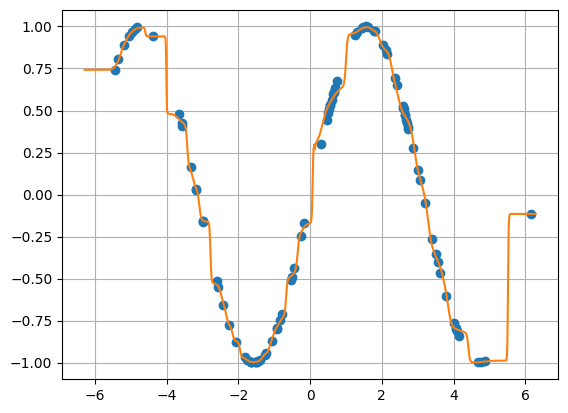

In [ ]:
plt.plot(x_normal, y_normal, 'o', label = "normal data points")
plt.plot(x_interp16, kernel_interpolate_with_variable_widths(x_normal, y_normal, x_interp16, gaussian), label="variable kernel widht, normal, gaussian")
print("variable kernel width, normal, gaussian MSE: ", mean_square_error(x_interp16, kernel_interpolate_with_variable_widths(x_normal, y_normal, x_interp16, gaussian), f1))

plt.grid()
plt.show()

fixed kernel width, normal, gaussian MSE:  0.021325221001189148


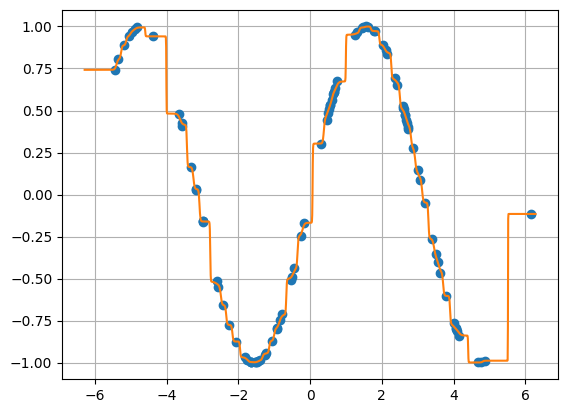

In [ ]:
plt.plot(x_normal, y_normal, 'o', label = "normal data points")
plt.plot(x_interp16, kernel_interpolate(x_normal, y_normal, x_interp16, gaussian), label="fixed kernel widht, normal, gaussian")
print("fixed kernel width, normal, gaussian MSE: ", mean_square_error(x_interp16, kernel_interpolate(x_normal, y_normal, x_interp16, gaussian), f1))

plt.grid()
plt.show()

classic gaussian MSE:  1.5313192405299908e-05


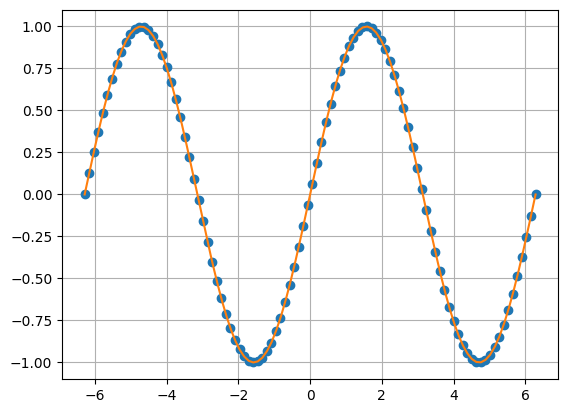

In [ ]:
plt.plot(x, y, 'o', label = "data points")
plt.plot(x_interp16, kernel_interpolate_with_variable_widths(x, y, x_interp16, linear), label="classic gaussian")
print("classic gaussian MSE: ", mean_square_error(x_interp16, kernel_interpolate(x, y, x_interp16, gaussian), f1))

plt.grid()
plt.show()

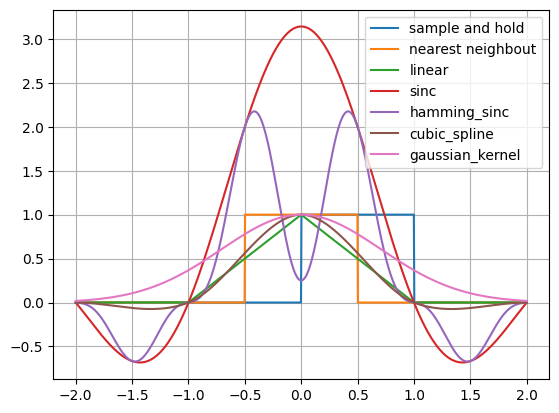

In [ ]:
x_test = np.linspace(-2, 2, 1000)
plt.plot(x_test, sample_and_hold(x_test), label="sample and hold")
plt.plot(x_test, nearest_neighbour(x_test), label="nearest neighbout")
plt.plot(x_test, linear(x_test), label="linear")
plt.plot(x_test, sinc(x_test), label="sinc")
plt.plot(x_test, hamming_sinc(x_test), label="hamming_sinc")
plt.plot(x_test, cubic_spline(x_test), label="cubic_spline")
plt.plot(x_test, gaussian(x_test), label="gaussian_kernel")
plt.grid()
plt.legend()
plt.show()

sinc MSE:  0.006967867876499591
cubic_spline MSE:  0.003779640897191477


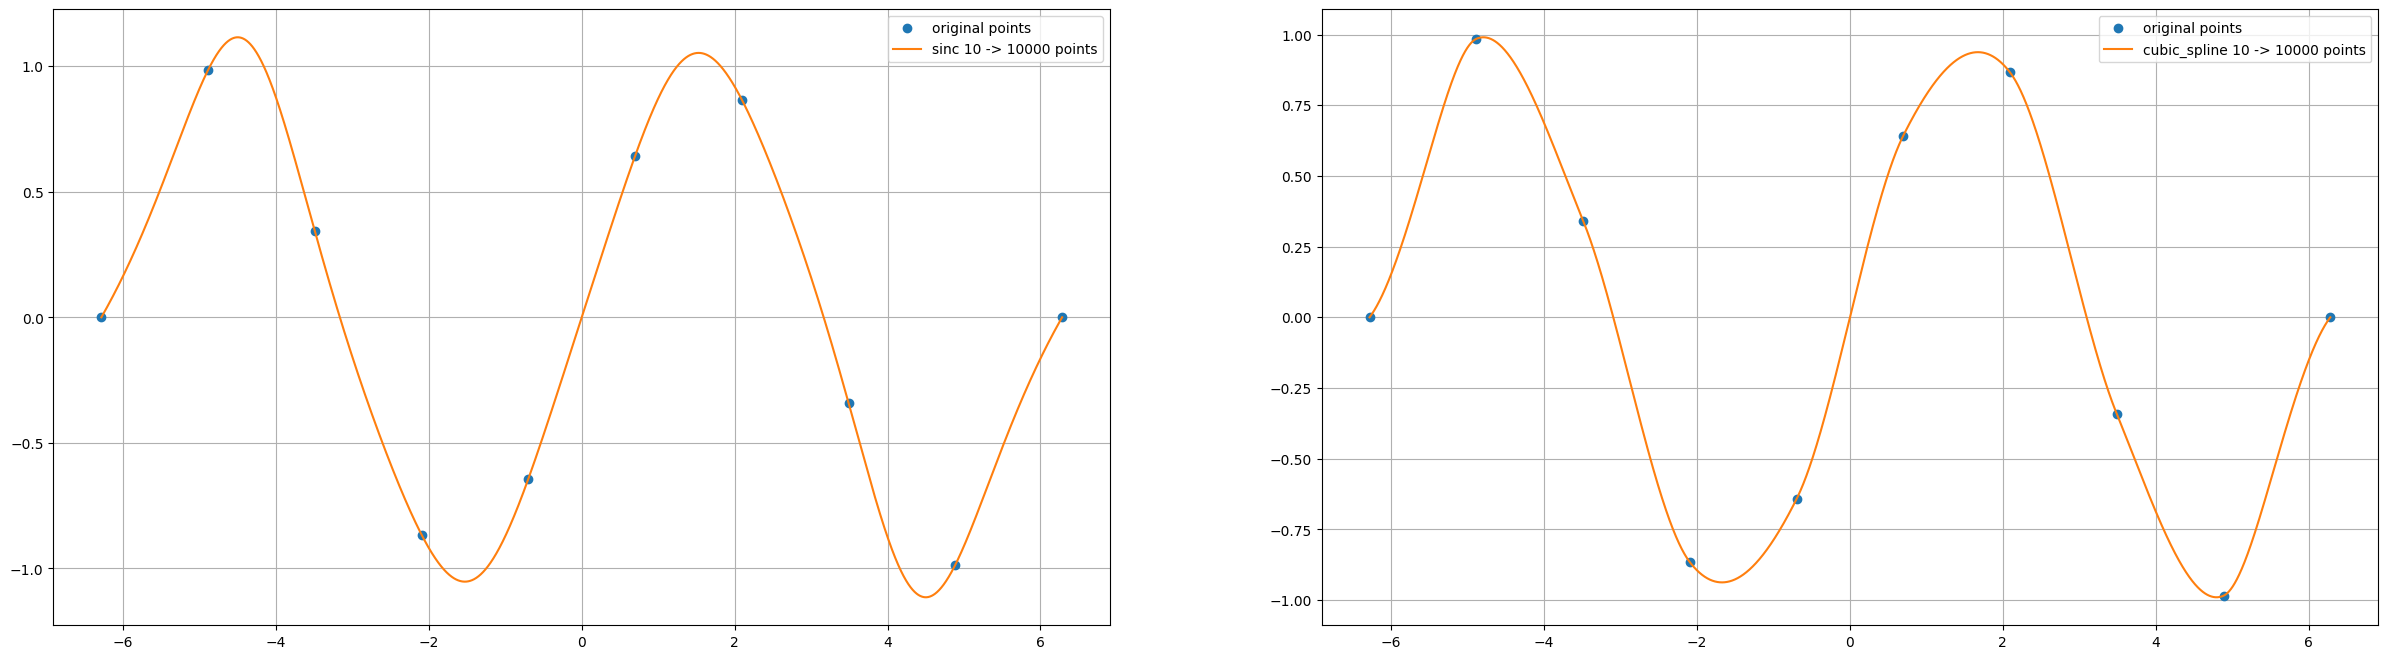

In [ ]:
fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (30, 8))
x_10 = np.linspace(-2 * np.pi, 2 * np.pi, 10)

ax[0].plot(x_10, f1(x_10), 'o', label="original points")
ax[0].plot(x_interp1000, kernel_interpolate(x_10, f1(x_10), x_interp1000, sinc), label="sinc 10 -> 10000 points")
print("sinc MSE: ", mean_square_error(x_interp1000, kernel_interpolate(x_10, f1(x_10), x_interp1000, sinc), f1))
ax[0].grid()
ax[0].legend()
ax[1].plot(x_10, f1(x_10), 'o', label="original points")
ax[1].plot(x_interp1000, kernel_interpolate(x_10, f1(x_10), x_interp1000, cubic_spline), label="cubic_spline 10 -> 10000 points")
print("cubic_spline MSE: ", mean_square_error(x_interp1000, kernel_interpolate(x_10, f1(x_10), x_interp1000, cubic_spline), f1))
ax[1].grid()
ax[1].legend()

plt.show()

gausian mse:  1.5313192405299908e-05
cubic_spline mse :  1.3152275208112575e-06
linear mse :  1.0802156542170432e-06
sample_and_hold mse :  0.0026815282216289195


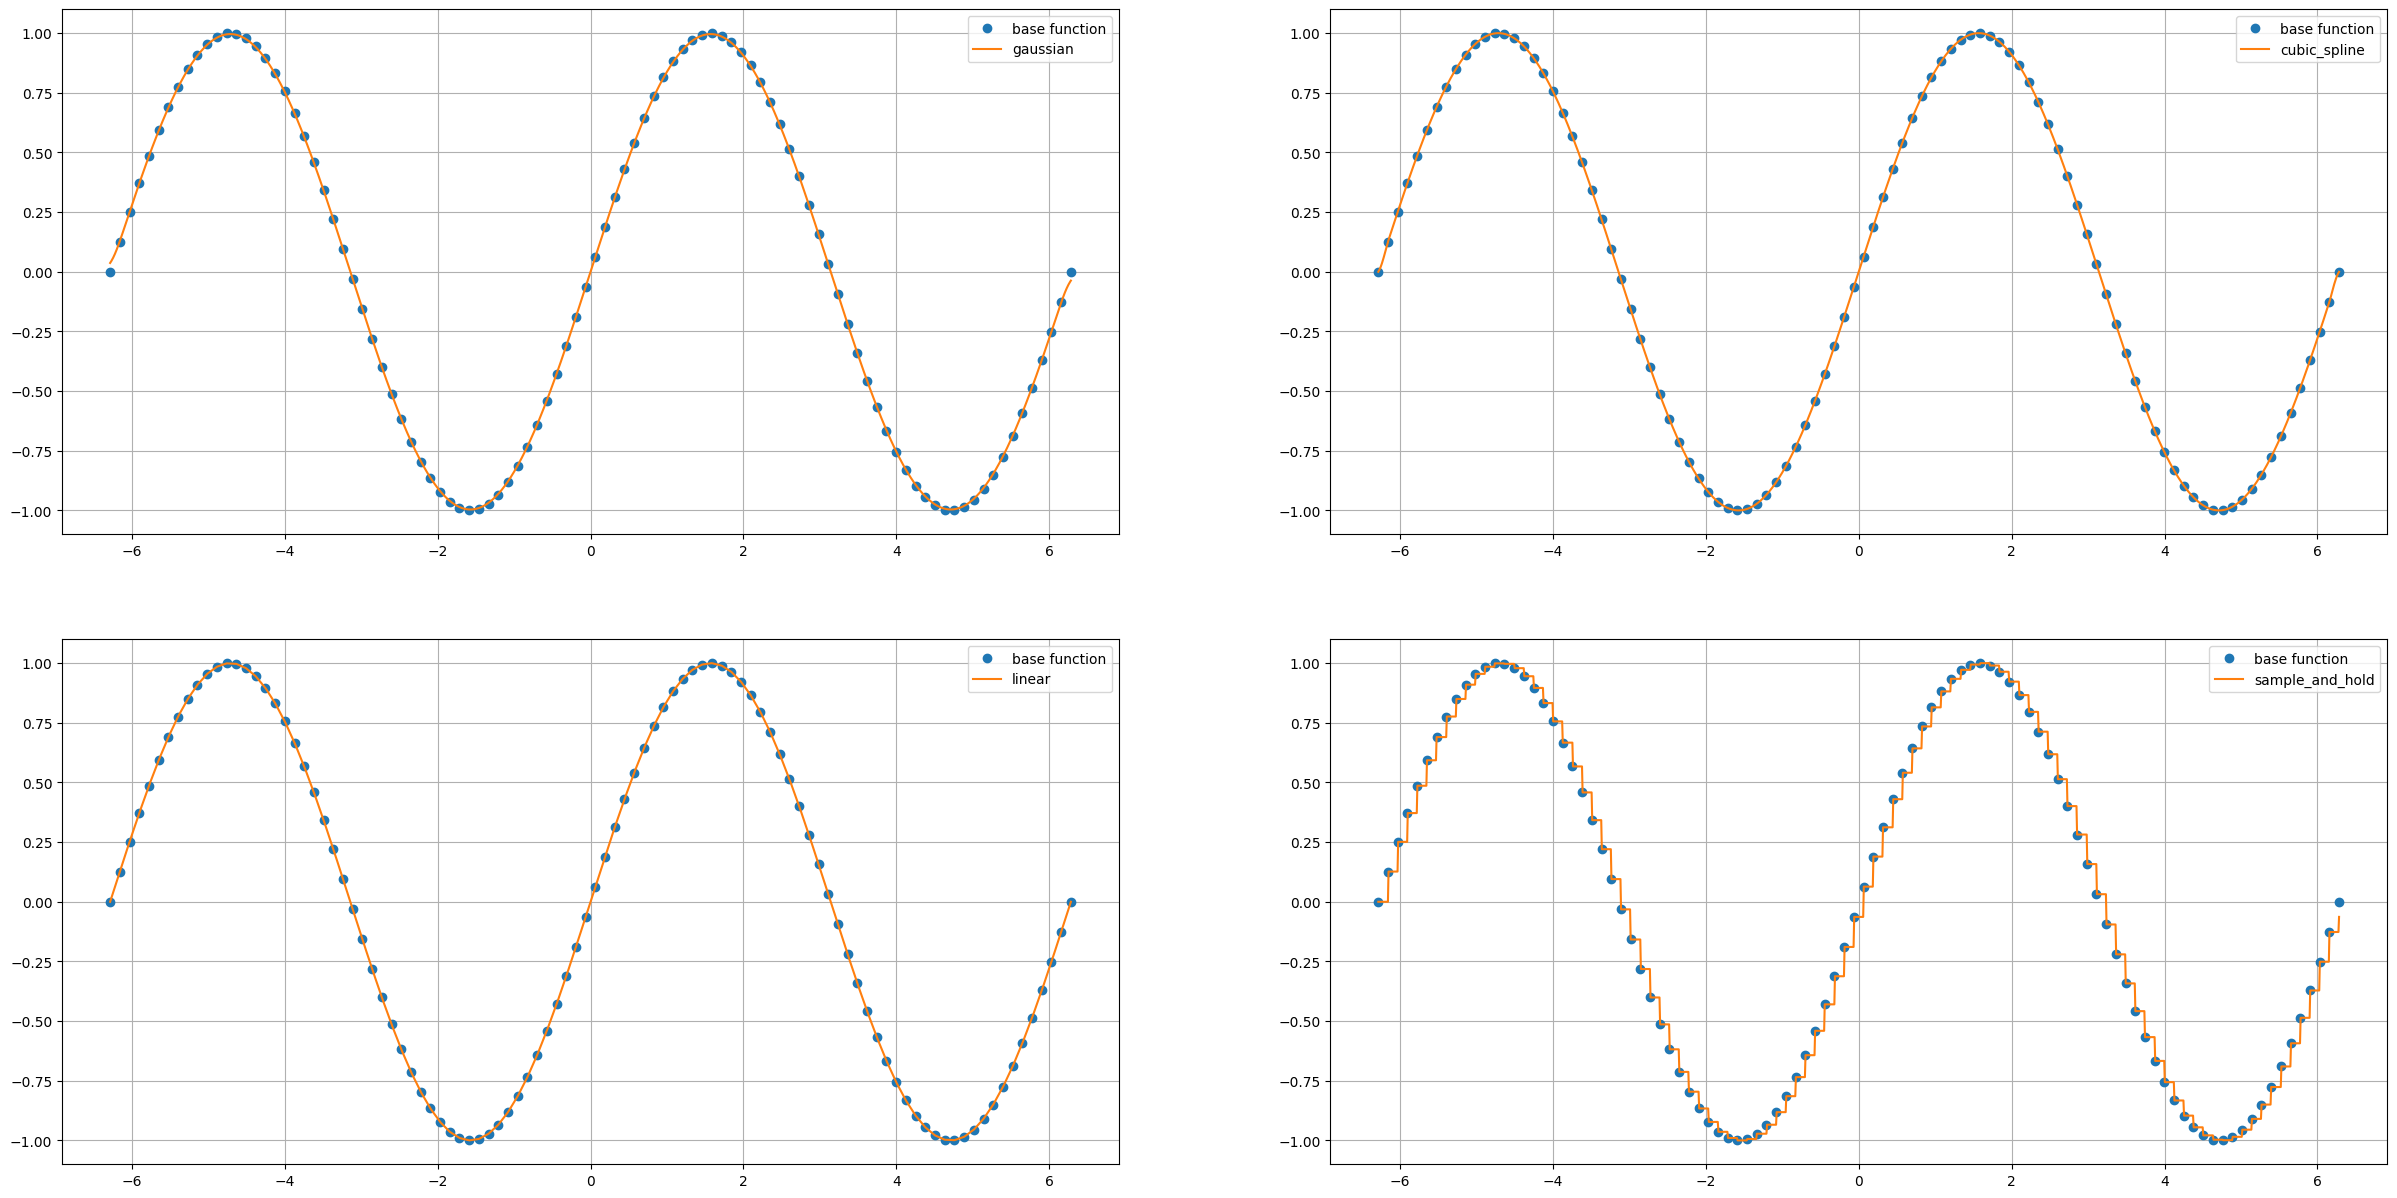

In [ ]:
fig, ax = plt.subplots(nrows = 2, ncols = 2, figsize = (30, 15))
ax[0, 0].plot(x, f1(x), 'o', label="base function")
ax[0, 0].plot(x_interp16, kernel_interpolate(x, f1(x), x_interp16, gaussian), label="gaussian")
print("gausian mse: ", mean_square_error(x_interp16, kernel_interpolate(x, f1(x), x_interp16, gaussian), f1))
ax[0, 0].grid()
ax[0, 0].legend()
ax[0, 1].plot(x, f1(x), 'o', label="base function")
ax[0, 1].plot(x_interp16, kernel_interpolate(x, f1(x), x_interp16, cubic_spline), label="cubic_spline")
print("cubic_spline mse : ",  mean_square_error(x_interp16, kernel_interpolate(x, f1(x), x_interp16, cubic_spline), f1))
ax[0, 1].grid()
ax[0, 1].legend()
ax[1, 0].plot(x, f1(x), 'o', label="base function")
ax[1, 0].plot(x_interp16, kernel_interpolate(x, f1(x), x_interp16, linear), label="linear")
print("linear mse : ", mean_square_error(x_interp16, kernel_interpolate(x, f1(x), x_interp16, linear), f1))
ax[1, 0].grid()
ax[1, 0].legend()
ax[1, 1].plot(x, f1(x), 'o', label="base function")
ax[1, 1].plot(x_interp16, kernel_interpolate(x, f1(x), x_interp16, sample_and_hold), label="sample_and_hold")
print("sample_and_hold mse : ", mean_square_error(x_interp16, kernel_interpolate(x, f1(x), x_interp16, sample_and_hold), f1))
ax[1, 1].grid()
ax[1, 1].legend()
plt.show()


cubic_spline MSE:  0.02160375226849754
hamming_sinc MSE:  0.020142070510938557
sinc MSE:  0.0201420705109386
linear MSE:  0.02073879920815492


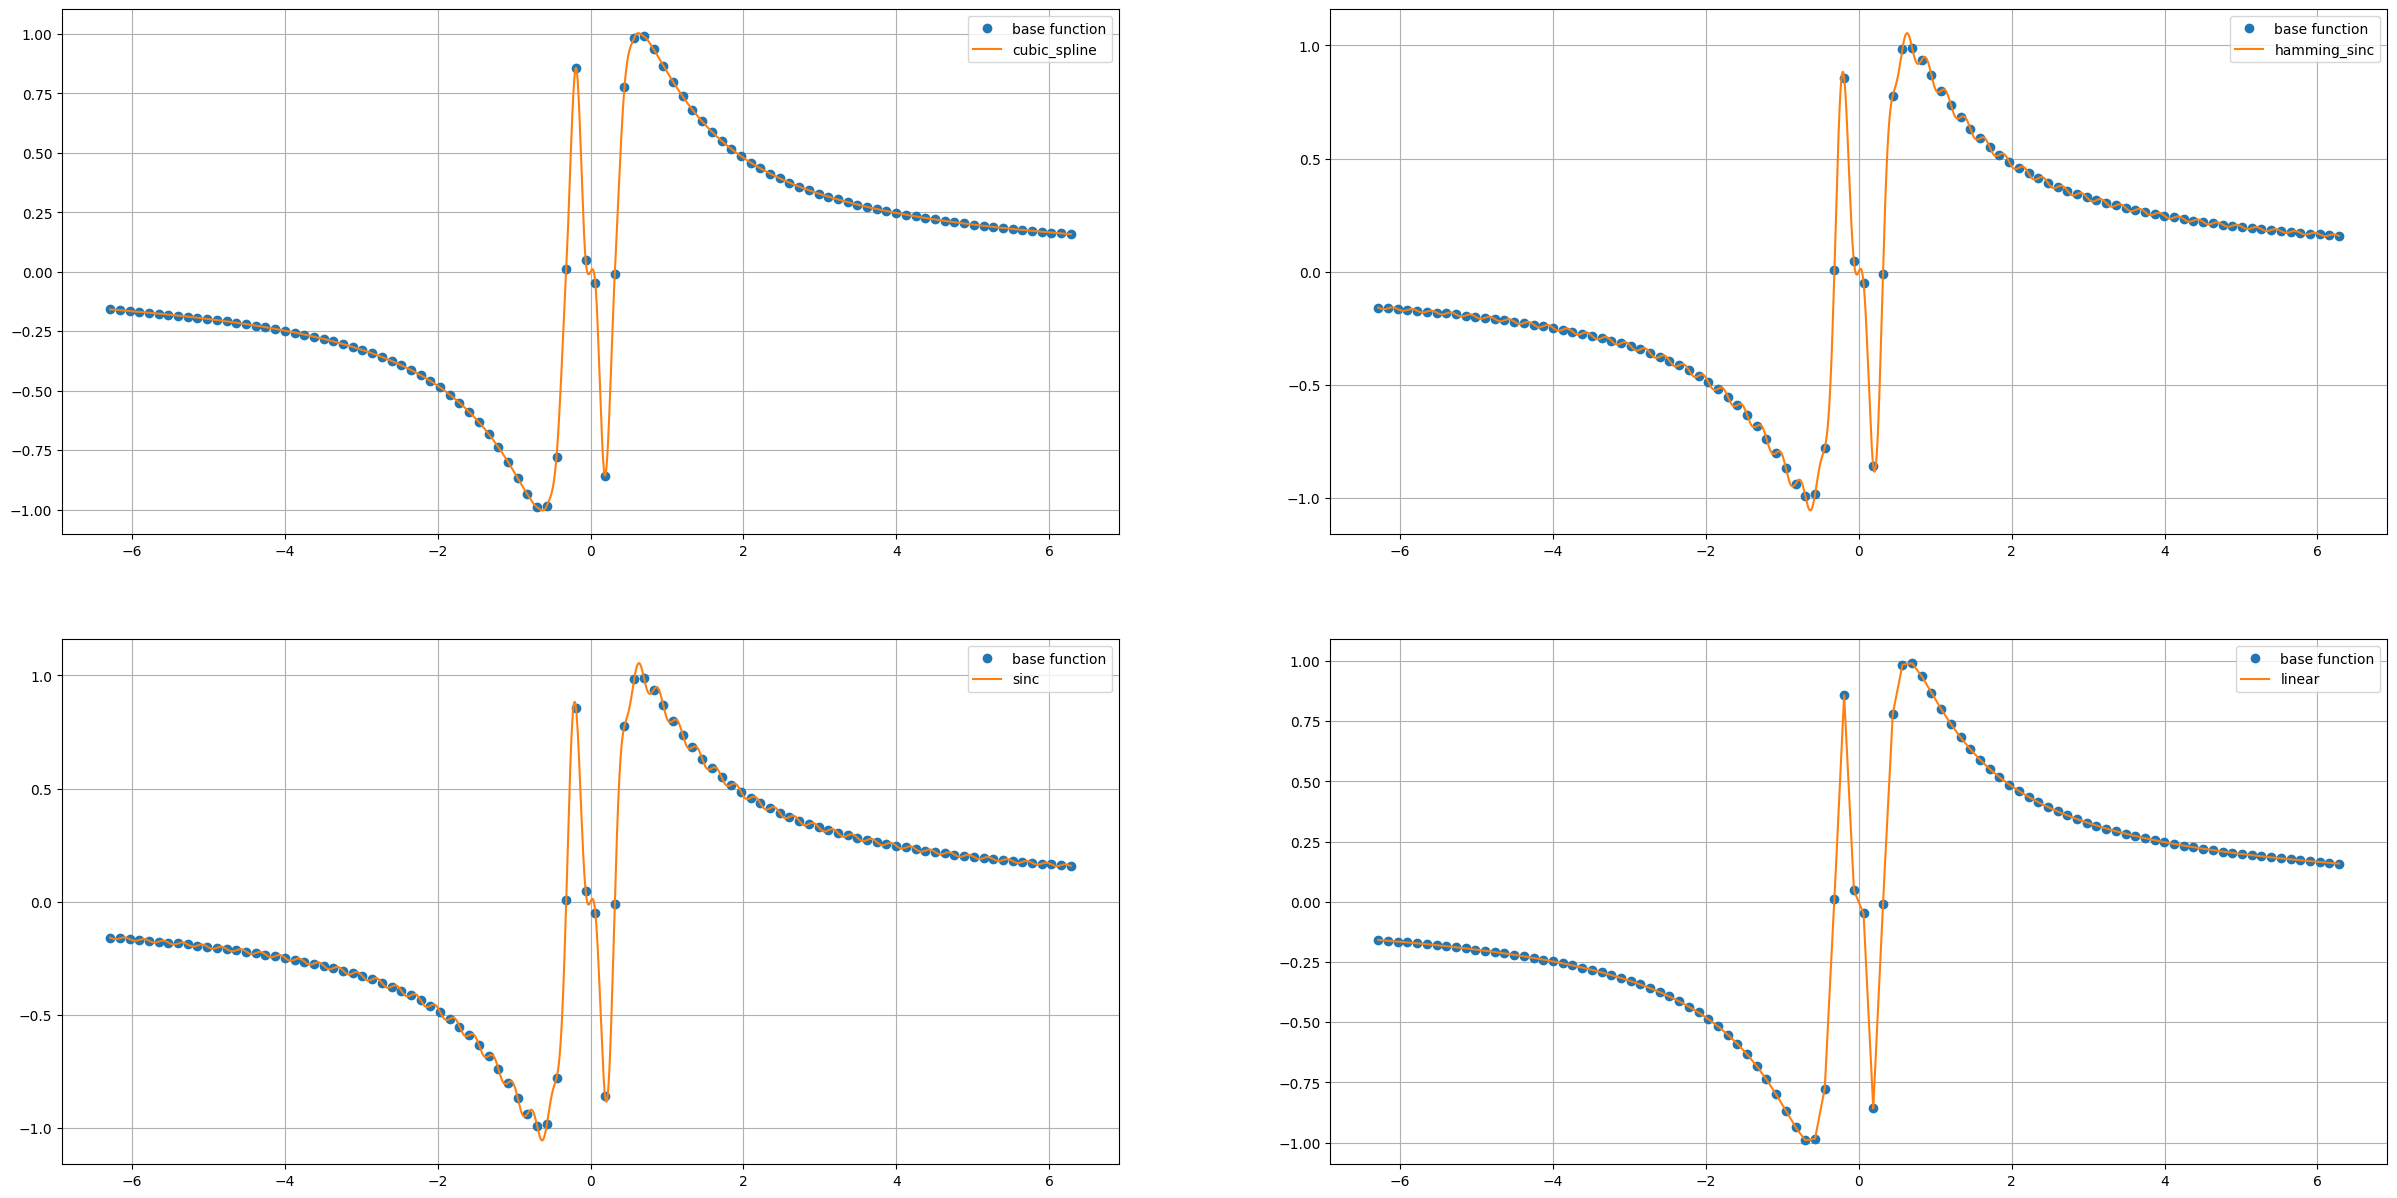

In [ ]:
fig, ax = plt.subplots(nrows = 2, ncols = 2, figsize = (30, 15))
ax[0, 0].plot(x, f2(x), 'o', label="base function")
ax[0, 0].plot(x_interp1000, kernel_interpolate(x, f2(x), x_interp1000, cubic_spline), label="cubic_spline")
print("cubic_spline MSE: ", mean_square_error(x_interp1000, kernel_interpolate(x, f2(x), x_interp1000, cubic_spline), f2))
ax[0, 0].grid()
ax[0, 0].legend()
ax[0, 1].plot(x, f2(x), 'o', label="base function")
ax[0, 1].plot(x_interp1000, kernel_interpolate(x, f2(x), x_interp1000, hamming_sinc), label="hamming_sinc")
print("hamming_sinc MSE: ", mean_square_error(x_interp1000, kernel_interpolate(x, f2(x), x_interp1000, hamming_sinc), f2))
ax[0, 1].grid()
ax[0, 1].legend()
ax[1, 0].plot(x, f2(x), 'o', label="base function")
ax[1, 0].plot(x_interp1000, kernel_interpolate(x, f2(x), x_interp1000, sinc), label="sinc")
print("sinc MSE: ", mean_square_error(x_interp1000, kernel_interpolate(x, f2(x), x_interp1000, sinc), f2))
ax[1, 0].grid()
ax[1, 0].legend()
ax[1, 1].plot(x, f2(x), 'o', label="base function")
ax[1, 1].plot(x_interp1000, kernel_interpolate(x, f2(x), x_interp1000, linear), label="linear")
print("linear MSE: ", mean_square_error(x_interp1000, kernel_interpolate(x, f2(x), x_interp1000, linear), f2))
ax[1, 1].grid()
ax[1, 1].legend()
plt.show()

sinc mse:  0.18758552708900827
cubic_spline mse :  0.20874933221322203
linear mse :  0.20197227722772282
nearest_neighbour mse :  0.3024


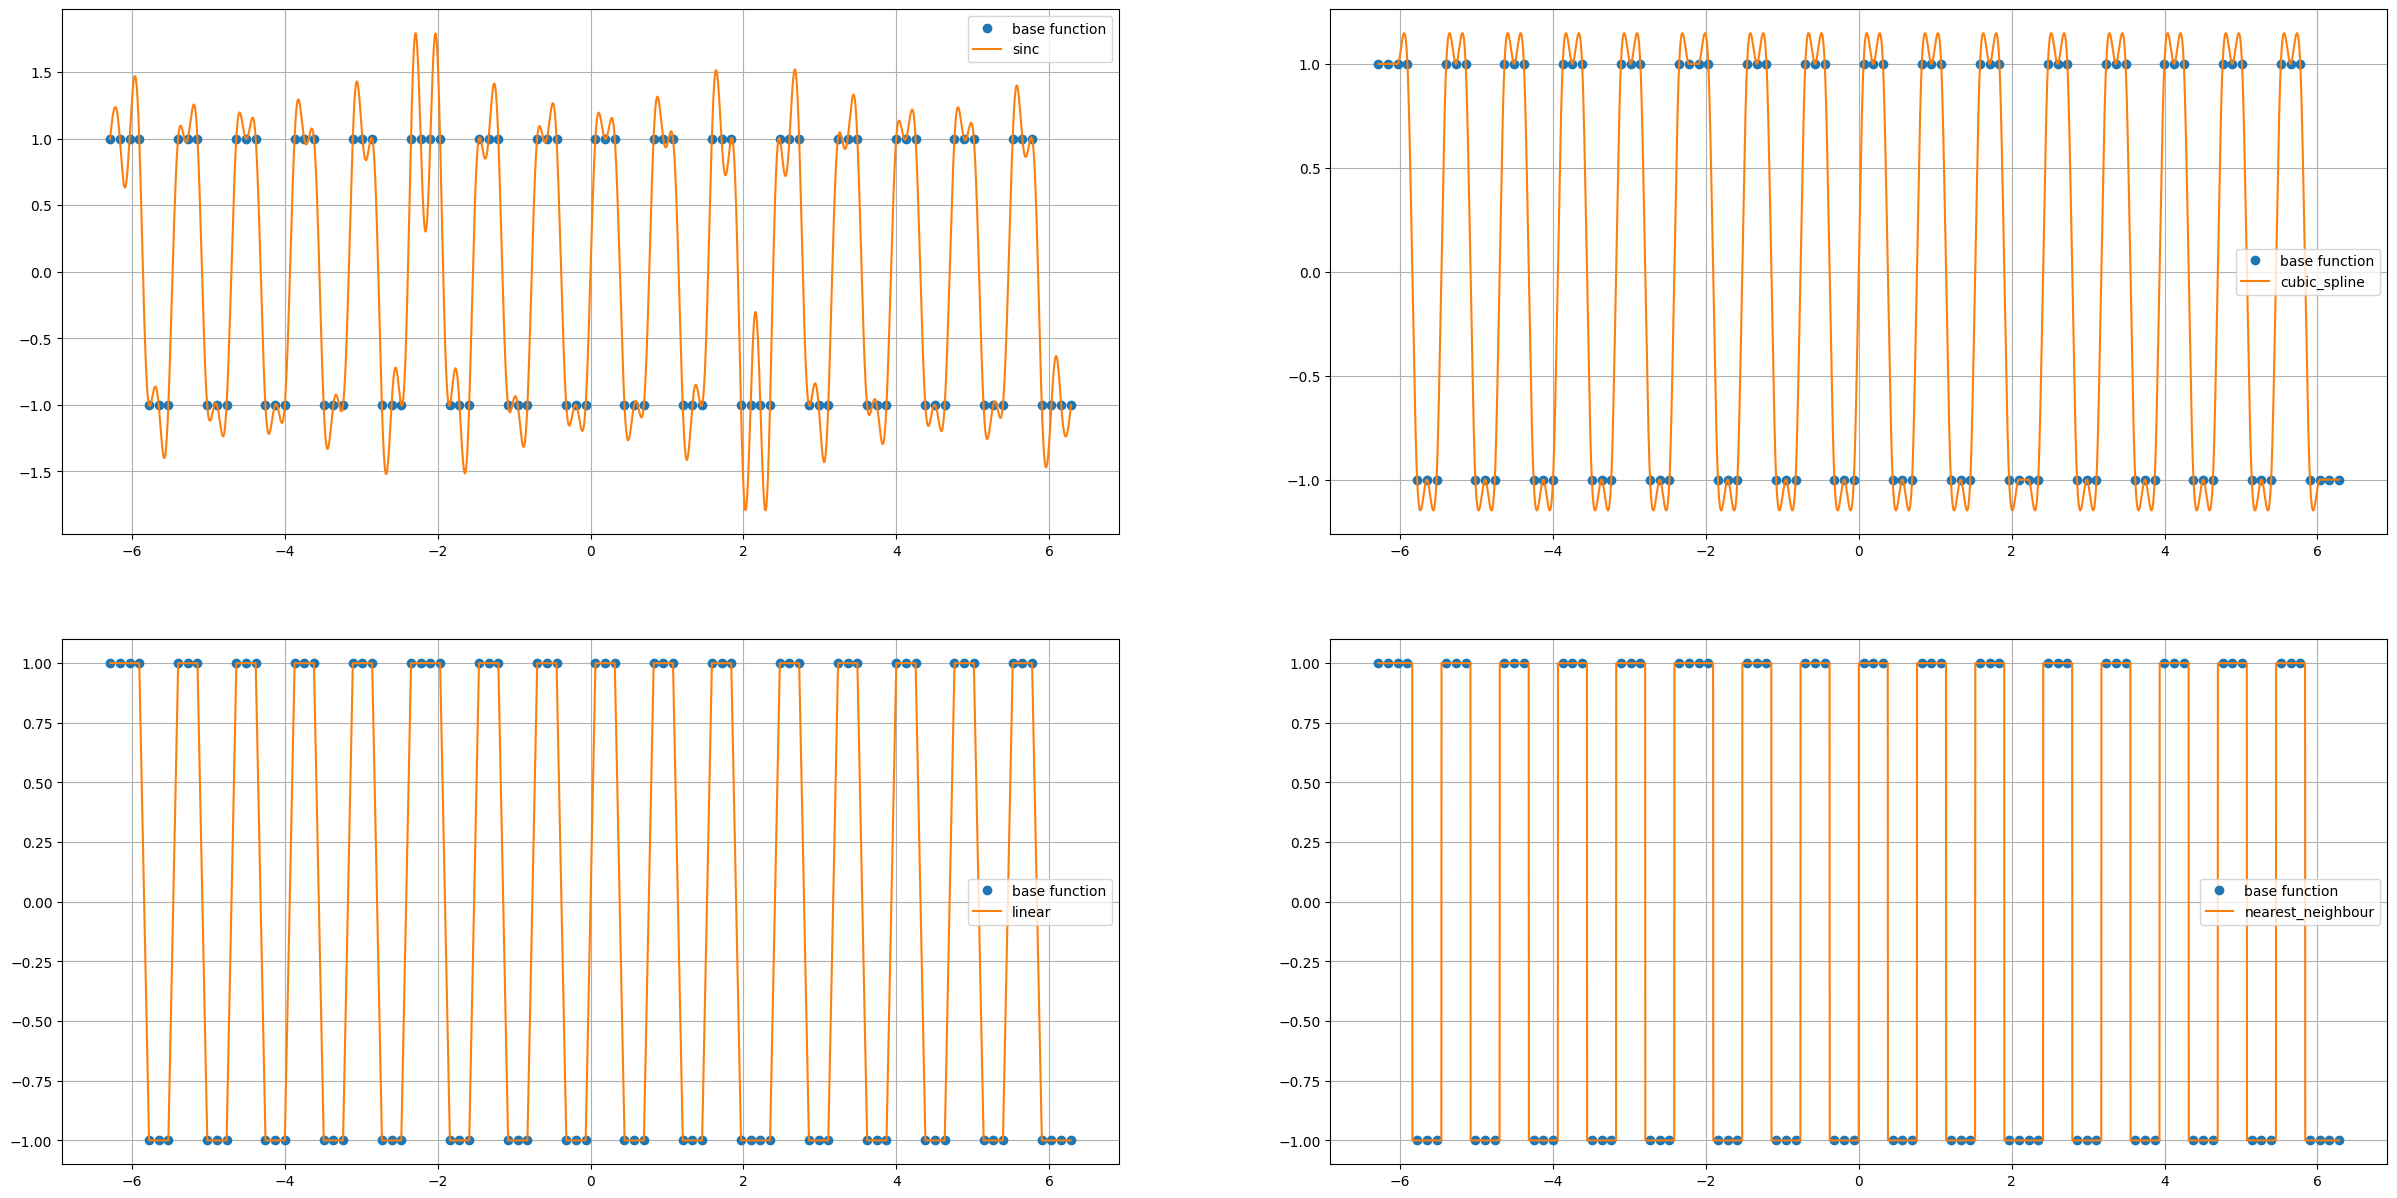

In [ ]:
fig, ax = plt.subplots(nrows = 2, ncols = 2, figsize = (30, 15))
ax[0, 0].plot(x, f3(x), 'o', label="base function")
ax[0, 0].plot(x_interp100, kernel_interpolate(x, f3(x), x_interp100, sinc), label="sinc")
print("sinc mse: ", mean_square_error(x_interp100, kernel_interpolate(x, f3(x), x_interp100, sinc), f3))
ax[0, 0].grid()
ax[0, 0].legend()
ax[0, 1].plot(x, f3(x), 'o', label="base function")
ax[0, 1].plot(x_interp100, kernel_interpolate(x, f3(x), x_interp100, cubic_spline), label="cubic_spline")
print("cubic_spline mse : ",  mean_square_error(x_interp100, kernel_interpolate(x, f3(x), x_interp100, cubic_spline), f3))
ax[0, 1].grid()
ax[0, 1].legend()
ax[1, 0].plot(x, f3(x), 'o', label="base function")
ax[1, 0].plot(x_interp100, kernel_interpolate(x, f3(x), x_interp100, linear), label="linear")
print("linear mse : ", mean_square_error(x_interp100, kernel_interpolate(x, f3(x), x_interp100, linear), f3))
ax[1, 0].grid()
ax[1, 0].legend()
ax[1, 1].plot(x, f3(x), 'o', label="base function")
ax[1, 1].plot(x_interp100, kernel_interpolate(x, f3(x), x_interp100, nearest_neighbour), label="nearest_neighbour")
print("nearest_neighbour mse : ", mean_square_error(x_interp100, kernel_interpolate(x, f3(x), x_interp100, nearest_neighbour), f3))
ax[1, 1].grid()
ax[1, 1].legend()
plt.show()



In [6]:
print("cubic_spline mse 2: ", 1000 * mean_square_error(x_interp2, kernel_interpolate(x, f1(x), x_interp2, cubic_spline), f1))
print("cubic_spline mse 4: ", 1000 *mean_square_error(x_interp4, kernel_interpolate(x, f1(x), x_interp4, cubic_spline), f1))
print("cubic_spline mse 10: ", 1000 *mean_square_error(x_interp10, kernel_interpolate(x, f1(x), x_interp10, cubic_spline), f1))
print("cubic_spline mse 16: ", 1000 * mean_square_error(x_interp16, kernel_interpolate(x, f1(x), x_interp16, cubic_spline), f1))
print("cubic_spline mse 1000: ", 1000 * mean_square_error(x_interp1000, kernel_interpolate(x, f1(x), x_interp1000, cubic_spline), f1))

cubic_spline mse 2:  0.001257364755002726
cubic_spline mse 4:  0.001306497402866518
cubic_spline mse 10:  0.001314577010598102
cubic_spline mse 16:  0.0013152275208112574
cubic_spline mse 1000:  0.0013160657532574572


1*16:  0.0013152275208112574
2*2*2*2:  7.916106679933384
(2*2*2*2) * multiplier:  2.1247112140313043


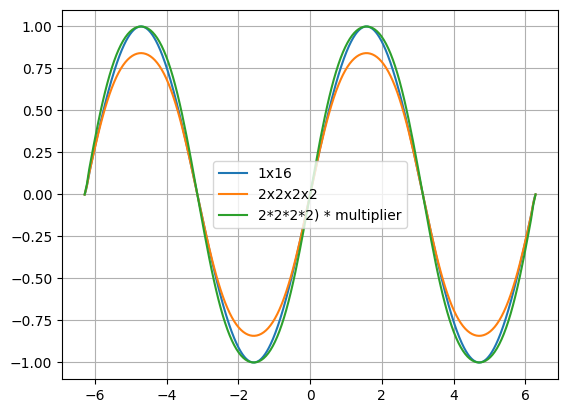

In [ ]:
fig, ax = plt.subplots()

print("1*16: ", 1000 * mean_square_error(x_interp16, kernel_interpolate(x, f1(x), x_interp16, cubic_spline), f1))
plt.plot(x_interp16, kernel_interpolate(x, f1(x), x_interp16, cubic_spline), label="1x16")

print("2*2*2*2: ", 1000 * mean_square_error(x_interp2, kernel_interpolate(x, f1(x), kernel_interpolate(x_interp2, kernel_interpolate(x_interp2, kernel_interpolate(x_interp2, kernel_interpolate(x_interp2, kernel_interpolate(x, f1(x), x_interp2, cubic_spline), x_interp2, cubic_spline), x_interp2, cubic_spline), x_interp2, cubic_spline), x_interp2, cubic_spline), cubic_spline), f1))
plt.plot(x_interp2, kernel_interpolate(x, f1(x), kernel_interpolate(x_interp2, kernel_interpolate(x_interp2, kernel_interpolate(x_interp2, kernel_interpolate(x_interp2, kernel_interpolate(x, f1(x), x_interp2, cubic_spline), x_interp2, cubic_spline), x_interp2, cubic_spline), x_interp2, cubic_spline), x_interp2, cubic_spline), cubic_spline), label="2x2x2x2")

multiplier = np.divide(1, np.max(kernel_interpolate(x, f1(x), kernel_interpolate(x_interp2, kernel_interpolate(x_interp2, kernel_interpolate(x_interp2, kernel_interpolate(x_interp2, kernel_interpolate(x, f1(x), x_interp2, cubic_spline), x_interp2, cubic_spline), x_interp2, cubic_spline), x_interp2, cubic_spline), x_interp2, cubic_spline), cubic_spline)))

print("(2*2*2*2) * multiplier: ", 1000 * mean_square_error(x_interp2, kernel_interpolate(x, f1(x), kernel_interpolate(x_interp2, kernel_interpolate(x_interp2, kernel_interpolate(x_interp2, kernel_interpolate(x_interp2, kernel_interpolate(x, f1(x), x_interp2, cubic_spline), x_interp2, cubic_spline), x_interp2, cubic_spline), x_interp2, cubic_spline), x_interp2, cubic_spline), cubic_spline) * multiplier, f1))
plt.plot(x_interp2, kernel_interpolate(x, f1(x), kernel_interpolate(x_interp2, kernel_interpolate(x_interp2, kernel_interpolate(x_interp2, kernel_interpolate(x_interp2, kernel_interpolate(x, f1(x), x_interp2, cubic_spline), x_interp2, cubic_spline), x_interp2, cubic_spline), x_interp2, cubic_spline), x_interp2, cubic_spline), cubic_spline) * multiplier, label="2*2*2*2) * multiplier")

plt.legend()
plt.grid()
plt.show()

In [ ]:
def convolution(data, kernel, kernel_size, step, padding = 0):
    result = []
    for i in range(0, len(data) - kernel_size, step):
        temp = []
        for j in range(0, len(data[0]) - kernel_size, step):
            if (i < (len(data)) - 1 and j < len(data[0]) - 1):
                temp.append(kernel((data[i:i+kernel_size,j:j+kernel_size]), kernel_size))
        result.append(temp)
    return np.array(result)

def graysacling(data):
    result = []
    for i in range(0, len(data)):
      temp = []
      for j in range(0, len(data[0])):
        temp.append(0.299 * data[i][j][0] + 0.587 * data[i][j][1] + 0.114 * data[i][j][2])
      result.append(temp)
    return np.array(result)

# [from, to, step]
def potato_slicing_convolution(data, times_smaller):
  return [row[::times_smaller] for row in data[::times_smaller]]

In [ ]:
def mean_kernel(data, matrix_size):
  sum = 0
  matrix = np.array([[1] * matrix_size] * matrix_size)
  for i in range(matrix_size):
    for j in range(matrix_size):
      sum += data[i][j] * matrix[i][j]
  return np.divide(sum, np.power(matrix_size, 2))

def rgb_mean_kernel(data, matrix_size):
  sum = [0] * 3
  matrix = np.array([[[1] * 3] * matrix_size] * matrix_size)
  for i in range(matrix_size):
    for j in range(matrix_size):
      for k in range(3):
        sum[k] += data[i][j][k] * matrix[i][j][k]
  sum = np.divide(sum, np.power(matrix_size, 2))
  return np.array(sum,  dtype=np.int32)

def max_pooling_kernel(data, matrix_size):
  return np.max([data[i][j] for i in range(len(data)) for j in range(len(data[0]))])

def rgb_max_pooling_kernel(data, matrix_size):
  result= [0] * 3
  r =  np.max([data[i][j][0] for i in range(len(data)) for j in range(len(data[0]))])
  g =  np.max([data[i][j][1] for i in range(len(data)) for j in range(len(data[0]))])
  b =  np.max([data[i][j][2] for i in range(len(data)) for j in range(len(data[0]))])
  result[0], result[1], result[2] = r, g, b
  return np.array(result,  dtype=np.int32)

In [ ]:
def division_reducer(data, increase_step, decrease_step, interpolation_function, convolution_function):
    print(f"photo will be reduced by {increase_step/decrease_step}")
    data = interpolate_2D(data, kernel_interpolate, increase_step, linear)
    data = convolution(data, mean_kernel, decrease_step, decrease_step)
    return data

In [ ]:
camera_grayscale = skimage.data.camera()

astronaut_color = skimage.data.astronaut()

astronaut_grayscale = graysacling(astronaut_color)

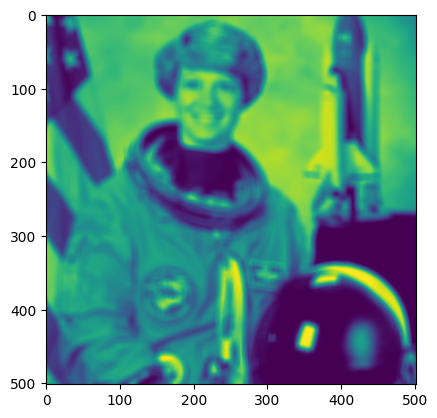

In [ ]:
plt.imshow(convolution(astronaut_grayscale, mean_kernel, 10, 1))
plt.show()

photo will be reduced by 0.6666666666666666


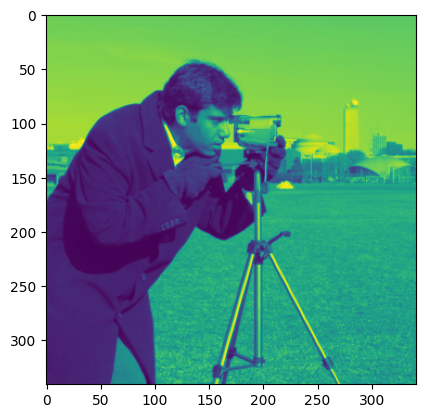

In [ ]:
plt.imshow(division_reducer(camera_grayscale, 2, 3, interpolate_2D, convolution))
plt.show()

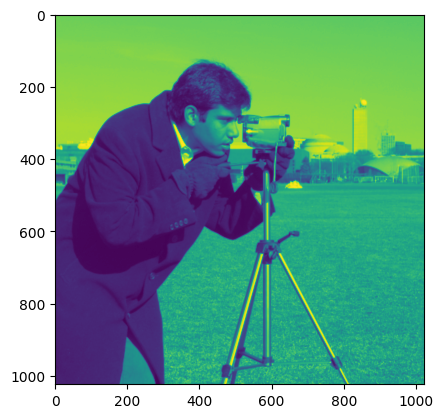

In [ ]:
camera_grayscale_interpolated_linear = interpolate_2D(camera_grayscale, kernel_interpolate, 2, linear)
camera_grayscale_interpolated_cubic_spline = interpolate_2D(camera_grayscale, kernel_interpolate, 2, cubic_spline)
plt.imshow(camera_grayscale_interpolated_linear)
plt.show()
plt.imshow(camera_grayscale_interpolated_cubic_spline)
plt.show()

In [ ]:
original_data = camera_grayscale
tested_data1 = division_reducer(camera_grayscale, 2, 2, interpolate_2D, convolution)
print(f"MSE for 1st loop: {mean_square_error_2D(original_data, tested_data1)}")
tested_data2 = division_reducer(tested_data1, 2, 2, interpolate_2D, convolution)
print(f"MSE for 2nd loop: {mean_square_error_2D(original_data, tested_data2)}")
tested_data3 = division_reducer(tested_data2, 2, 2, interpolate_2D, convolution)
print(f"MSE for 3rd loop: {mean_square_error_2D(original_data, tested_data3)}")
tested_data4 = division_reducer(tested_data3, 2, 2, interpolate_2D, convolution)
print(f"MSE for 4th loop: {mean_square_error_2D(original_data, tested_data4)}")

photo will be reduced by 1.0
MSE for 1st loop: 8424.871717445616
photo will be reduced by 1.0
MSE for 2nd loop: 21298.9415664262
photo will be reduced by 1.0
MSE for 3rd loop: 33315.624746555375
photo will be reduced by 1.0
MSE for 4th loop: 44092.67326772124


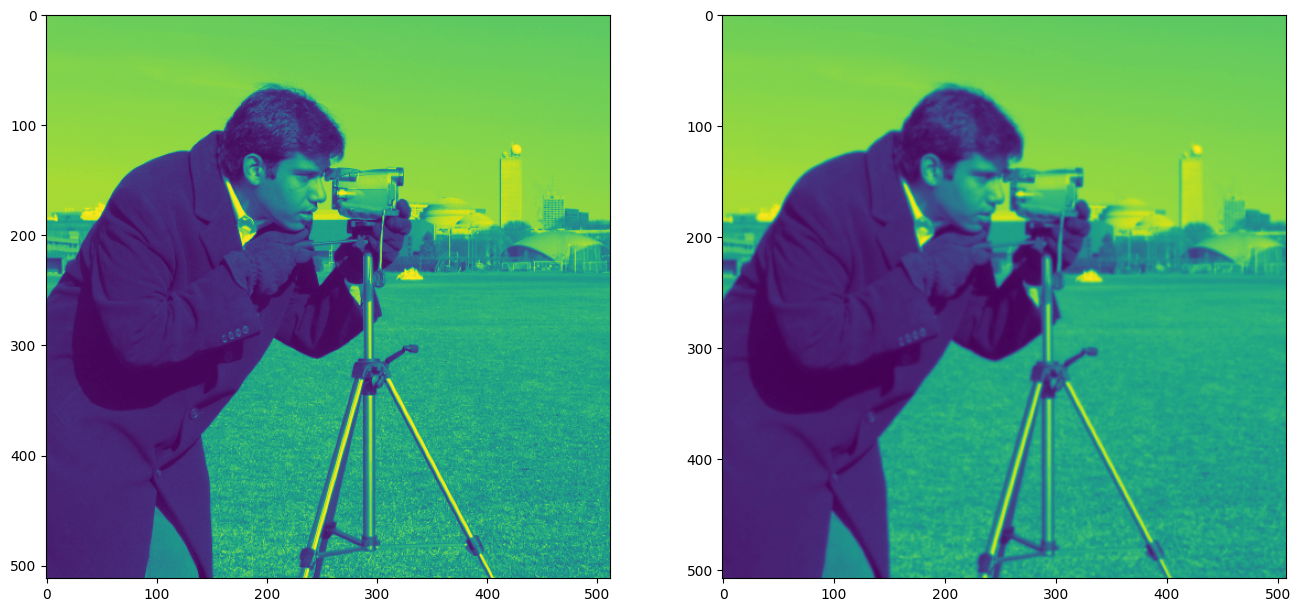

In [ ]:
fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (16, 8))
ax[0].imshow(original_data)
ax[1].imshow(tested_data4)
plt.show()

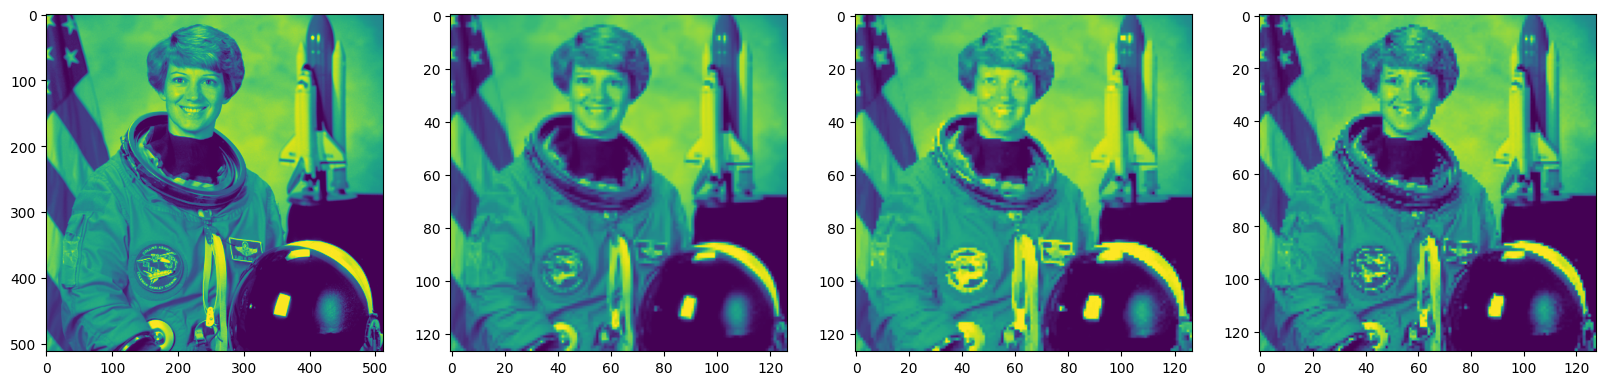

In [ ]:
fig, ax = plt.subplots(nrows = 1, ncols = 4, figsize = (20, 10))
ax[0].imshow(astronaut_grayscale)
ax[1].imshow(convolution(astronaut_grayscale, mean_kernel, 4, 4))
ax[2].imshow(convolution(astronaut_grayscale, max_pooling_kernel, 4, 4))
ax[3].imshow(potato_slicing_convolution(astronaut_grayscale, 4))
plt.show()

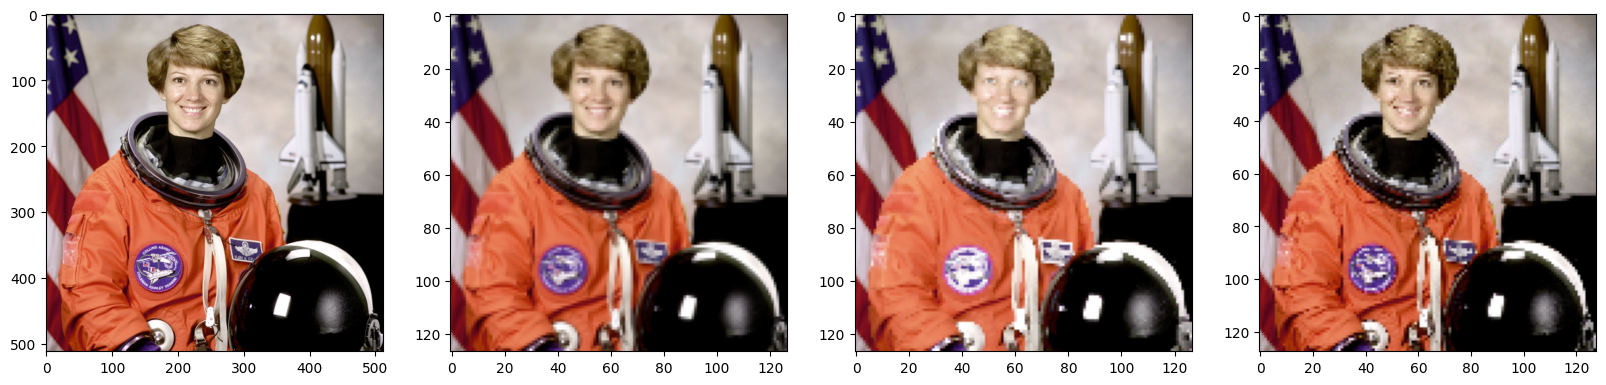

In [ ]:
fig, ax = plt.subplots(nrows = 1, ncols = 4, figsize = (20, 10))
ax[0].imshow(astronaut_color)
ax[1].imshow(convolution(astronaut_color, rgb_mean_kernel, 4, 4, 0))
ax[2].imshow(convolution(astronaut_color, rgb_max_pooling_kernel, 4, 4, 0))
ax[3].imshow(potato_slicing_convolution(astronaut_color, 4))
plt.show()